In [1]:
#imports
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import io
import cv2
import csv
import skimage.io

In [39]:
#path to the training file
data_directory = "D:\image_training"
files_training = os.listdir(data_directory)


In [40]:
#file name and category matrix
categories = ["healthy eye", "diabetic rectinopathy stage 1", "diabetic rectinopathy stage 2", "diabetic rectinopathy stage 3", "diabetic rectinopathy stage 4", "glaucoma", "cataracts"]
file_names = []
labels = []
IMG_SIZE = 150

#adds file name to category
for filename in files_training:
    if filename[0:2] == "NL":
        labels.append(0)
        file_names.append(filename)
    if filename[22:23] == "0":
        labels.append(0)
        file_names.append(filename)
    if filename[22:23] == "1":
        labels.append(1)
        file_names.append(filename)
    if filename[22:23] == "2":
        labels.append(2)
        file_names.append(filename)
    if filename[22:23] == "3":
        labels.append(3)
        file_names.append(filename)
    if filename[22:23] == "4":
        labels.append(4)
        file_names.append(filename)
    if filename[0:4] == "Glau":
        labels.append(5)
        file_names.append(filename)
    if filename[0:3] == "cat":
        labels.append(6)
        file_names.append(filename)

    #combines matrix in a dataframe
data = pd.DataFrame({
    'filename' : file_names,
    'label' : labels,
})

In [41]:
print(data)

filename  label
0    diabetic_rectinopathy-0-0a902c80d5da.png      0
1    diabetic_rectinopathy-0-0abf0c485f66.png      0
2                 diabetic_rectinopathy-0.png      0
3    diabetic_rectinopathy-0-00cc2b75cddd.png      0
4    diabetic_rectinopathy-0-00f6c1be5a33.png      0
..                                        ...    ...
461                                NL_298.png      0
462                                NL_299.png      0
463                                NL_300.png      0
464                                NL_023.png      0
465                                NL_024.png      0

[466 rows x 2 columns]


0    338
5     53
6     34
1     11
4     10
3     10
2     10
Name: label, dtype: int64


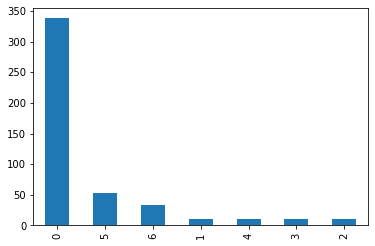

In [42]:
#plots the data being used
data['label'].value_counts().plot.bar()
print(data['label'].value_counts())

In [43]:
#Crop image
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark to crop
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    		#print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    		#print(img.shape)
        return img

#Enhance colors and add halo around eye
def color_crop_enhance(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX),-4,128)
    return image

#Display 10 images
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#Create training list of image arrays
def create_input_data(folder_path):
    train_data = []
    for img in os.listdir(data_directory):
        image = color_crop_enhance(os.path.join(data_directory,img))
        train_data.append(image)
    return np.array(train_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

train_images = create_input_data(data_directory)

#Scale pixel values
train_images = train_images / 255.0

#Create array of training labels
train_labels = np.array(data['label'])


#ADD TEST DATA TO EVALUATE MODEL ON!!!

In [46]:
#Build Model
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(7), #Each output node is a score of the three classes
    keras.layers.Softmax()
])

#Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train Model
model.fit(train_images, train_labels, batch_size=10, epochs=5)


Epoch 1/5
47/47 [==============================] - 13s 287ms/step - loss: 1.4444 - accuracy: 0.7253
Epoch 2/5
47/47 [==============================] - 12s 263ms/step - loss: 1.4401 - accuracy: 0.7253
Epoch 3/5
47/47 [==============================] - 12s 261ms/step - loss: 1.4401 - accuracy: 0.7253
Epoch 4/5
47/47 [==============================] - 13s 285ms/step - loss: 1.4401 - accuracy: 0.7253
Epoch 5/5
47/47 [==============================] - 14s 303ms/step - loss: 1.4401 - accuracy: 0.7253


In [47]:

#Save Model
model.save('firstRetinalNN.model')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: firstRetinalNN.model\assets
INFO:tensorflow:Assets written to: firstRetinalNN.model\assets
